In [1]:
import pathlib

from astropy.convolution import Gaussian2DKernel, convolve
import astropy.coordinates as coord
from astropy.io import ascii
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import binned_statistic, binned_statistic_2d

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

from pyia import GaiaData

In [3]:
joined = at.Table.read(
    pathlib.Path('~/data/Asteroseismology/TESS_Hon2021_GaiaEDR3.fits').expanduser(),
    hdu=1)

rave = at.Table.read(
    pathlib.Path('~/data/RAVE/rave_gaia_xmatch.fits').expanduser())
rave.rename_column('RAVE_OBS_ID', 'rave_obs_id')

rave_pars = at.Table.read(
    pathlib.Path('~/data/RAVE/dr6_gauguin_madera.fits').expanduser())
rave = at.join(rave, rave_pars, keys='rave_obs_id')

joined = at.join(joined, rave, keys='source_id', 
                 join_type='left')
joined = at.unique(joined, keys='TIC')
len(joined)

158505

In [5]:
edr3_actions = at.Table.read(
    pathlib.Path('~/data/Gaia/EDR3/edr3-rv-good-plx-result-actions.fits').expanduser())
joined = at.join(joined, edr3_actions, 
                 keys='source_id', join_type='left')
len(joined)

158505

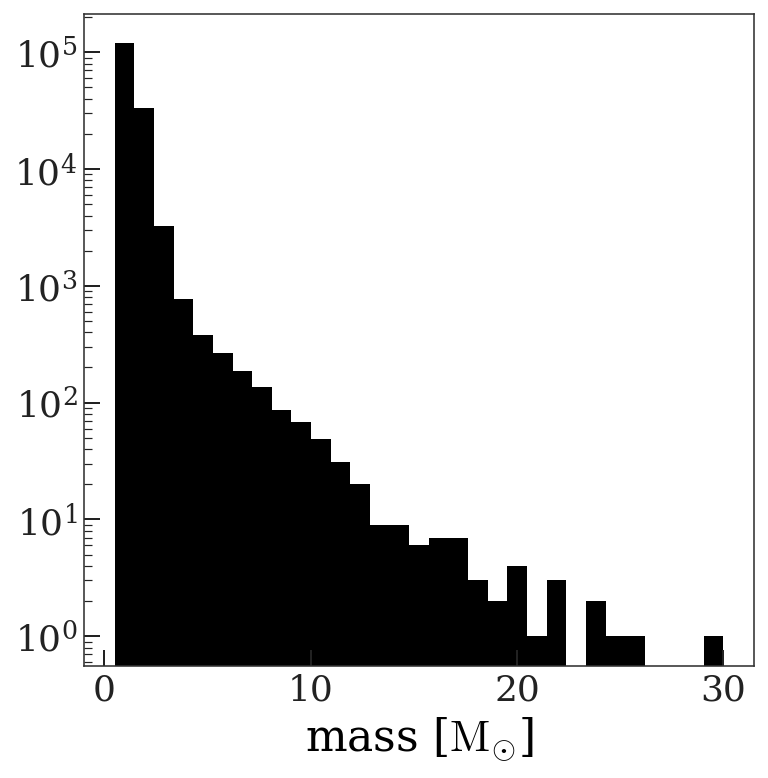

In [6]:
plt.hist(joined['mass'], bins=np.linspace(0.5, 30, 32));
plt.yscale('log')
plt.xlabel(f'mass [{u.Msun:latex_inline}]');

In [7]:
g = GaiaData(joined)

mask = (
    np.isfinite(g.dr2_radial_velocity) &
    (g.massflag == 1) &
    (g.mass < 20*u.Msun)
)
g = g[mask]
c = g.get_skycoord(radial_velocity=g.dr2_radial_velocity)
len(g)

149830

Compute kinematic quantities:

In [8]:
vcirc = 229 * u.km/u.s
galcen_frame = coord.Galactocentric()
galcen_frame

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>

In [9]:
galcen = c.transform_to(galcen_frame)
w0 = gd.PhaseSpacePosition(galcen.data)
L = w0.angular_momentum()
Lz = L[2]

cyl = galcen.cylindrical
vcyl = galcen.cylindrical.differentials['s']
vR = vcyl.d_rho.to_value(u.km/u.s)
vphi = (cyl.rho * vcyl.d_phi).to_value(u.km/u.s, u.dimensionless_angles())

In [10]:
vz_z_bins = (
    np.arange(-75, 75+1e-3, 1.),
    np.arange(-1.5, 1.5+1e-3, 25/1e3)
)

[109928, 33010, 5847, 1045]


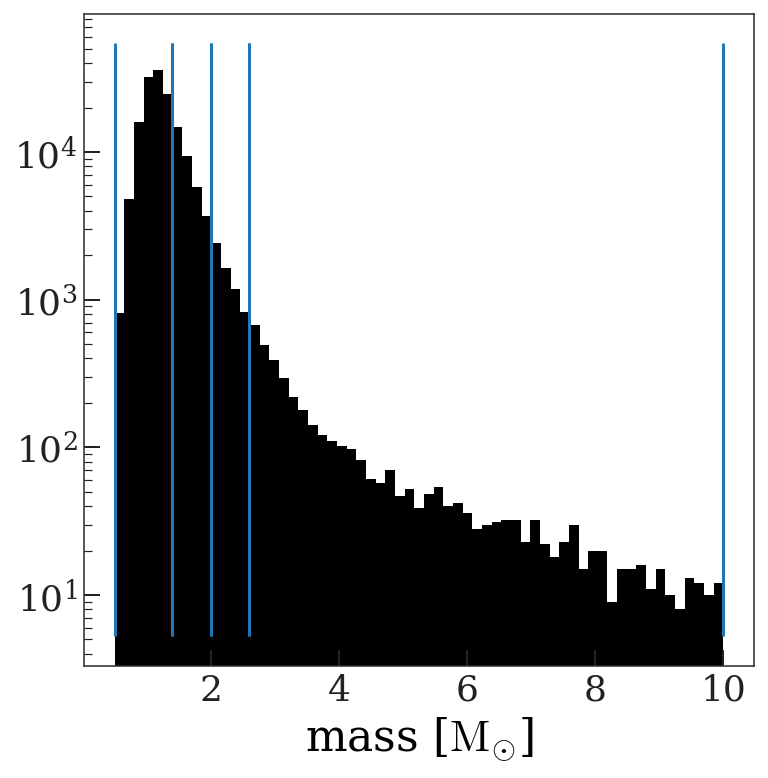

In [11]:
mass_bins = [
    (0.5, 1.4),
    (1.4, 2),
    (2, 2.6),
    (2.6, 10)
]
print([((g.mass.value > m1) & (g.mass.value < m2)).sum()
       for m1, m2 in mass_bins])

plt.hist(joined['mass'], bins=np.linspace(0.5, 10, 64));
plt.yscale('log')
plt.xlabel(f'mass [{u.Msun:latex_inline}]');
plt.vlines(np.ravel(mass_bins),
           plt.ylim()[0], plt.ylim()[1], 
           color='tab:blue')

/mnt/home/apricewhelan/anaconda3/lib/python3.9/site-packages/astropy/convolution/convolve.py:405: AstropyUserWarning: nan_treatment='interpolate', however, NaN values detected post convolution. A contiguous region of NaN values, larger than the kernel size, are present in the input array. Increase the kernel size to avoid this.
  warnings.warn("nan_treatment='interpolate', however, NaN values detected "



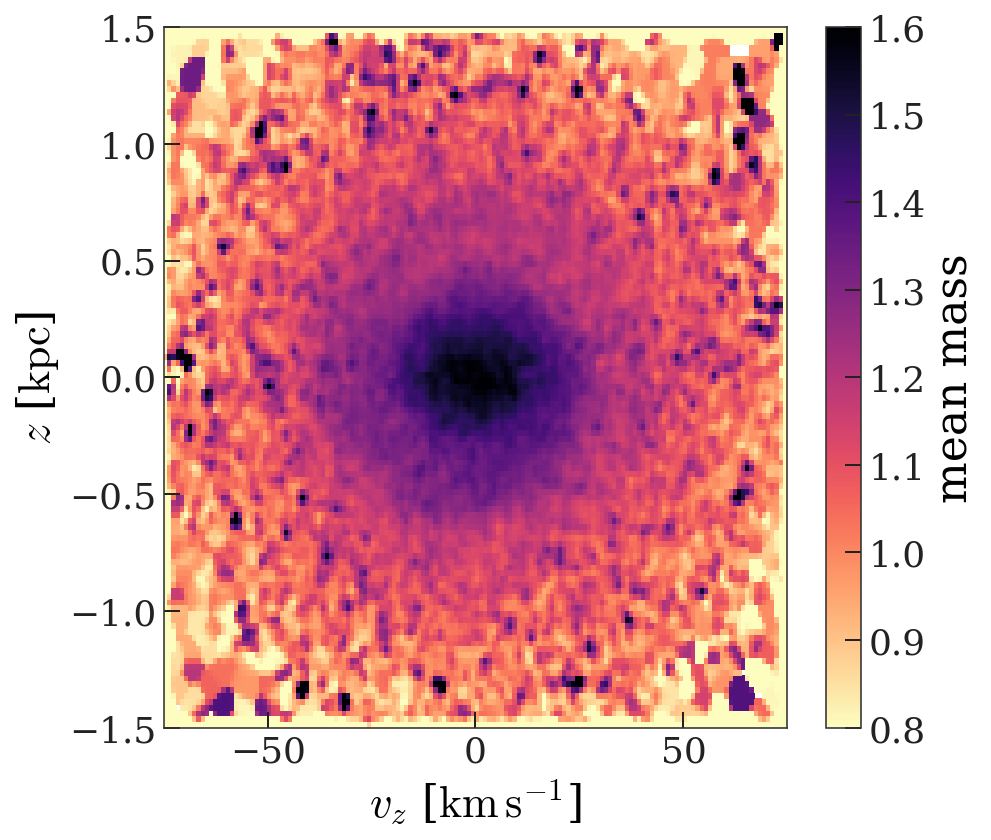

In [14]:
Lz_mask = np.abs(Lz_solar - 1.) < 0.15

fig, ax = plt.subplots(figsize=(7, 6))

stat = binned_statistic_2d(
    galcen.v_z.to_value(u.km/u.s)[Lz_mask],
    galcen.z.to_value(u.kpc)[Lz_mask],
    g.mass.value[Lz_mask],
    statistic=np.mean,
    bins=vz_z_bins
)
H = stat.statistic.T

kernel = Gaussian2DKernel(x_stddev=0.8)
H = convolve(H, kernel)

cs = ax.pcolormesh(
    stat.x_edge, stat.y_edge, 
    H, 
    vmin=0.8, vmax=1.6,
    cmap='magma_r')

cb = fig.colorbar(cs)
cb.set_label('mean mass')

ax.set_xlabel(f'$v_z$ [{u.km/u.s:latex_inline}]')
ax.set_ylabel(f'$z$ [{u.kpc:latex_inline}]')

fig.tight_layout()

[65817, 98297, 70525, 19373]


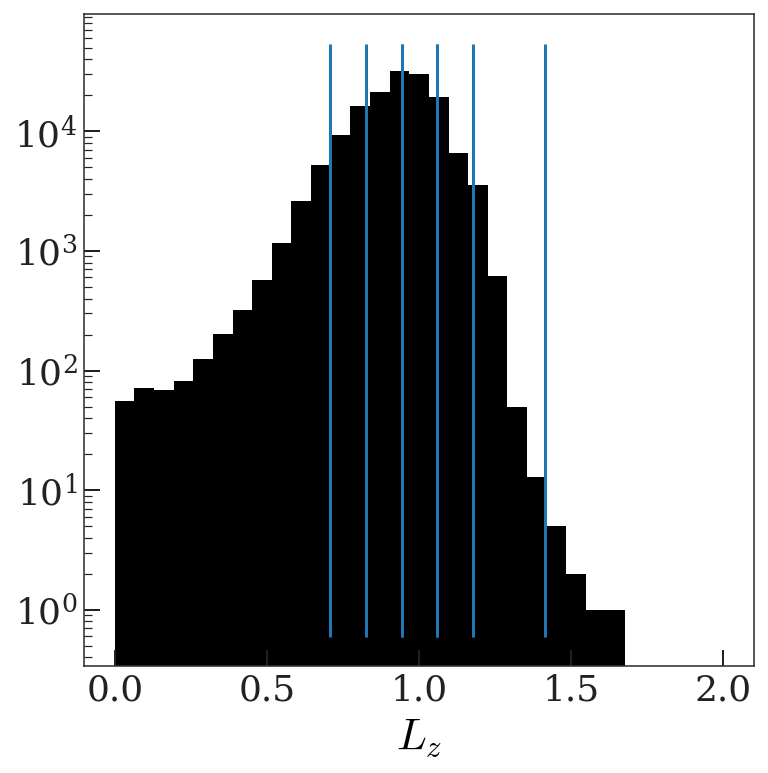

In [13]:
Lz_sun = 240*u.km/u.s * 8.1*u.kpc
Lz_solar = -Lz.to_value(Lz_sun)

Rg_bins = [
    [6, 8],
    [7, 9],
    [8, 10],
    [9, 12]
] * u.kpc
Lz_bins = (Rg_bins * vcirc).to_value(Lz_sun)

# Lz_bins = [
#     (0.7, 0.9), 
#     (0.9, 1.),
#     (1., 1.1),
#     (1.1, 1.2)
# ]
print([((Lz_solar > m1) & (Lz_solar < m2)).sum()
       for m1, m2 in Lz_bins])

plt.hist(Lz_solar,
         bins=np.linspace(0, 2, 32));
plt.yscale('log')
plt.xlabel('$L_z$');
plt.vlines(np.ravel(Lz_bins),
           plt.ylim()[0], plt.ylim()[1], 
           color='tab:blue')

In [15]:
from astropy.stats import median_absolute_deviation as MAD

/tmp/ipykernel_227351/2198091771.py:71: RuntimeWarning: divide by zero encountered in log
  this_H = np.log(this_H)

/tmp/ipykernel_227351/2198091771.py:71: RuntimeWarning: divide by zero encountered in log
  this_H = np.log(this_H)

/mnt/home/apricewhelan/anaconda3/lib/python3.9/site-packages/astropy/convolution/convolve.py:405: AstropyUserWarning: nan_treatment='interpolate', however, NaN values detected post convolution. A contiguous region of NaN values, larger than the kernel size, are present in the input array. Increase the kernel size to avoid this.
  warnings.warn("nan_treatment='interpolate', however, NaN values detected "

/tmp/ipykernel_227351/2198091771.py:71: RuntimeWarning: divide by zero encountered in log
  this_H = np.log(this_H)

/mnt/home/apricewhelan/anaconda3/lib/python3.9/site-packages/astropy/convolution/convolve.py:405: AstropyUserWarning: nan_treatment='interpolate', however, NaN values detected post convolution. A contiguous region of NaN values, larger than 

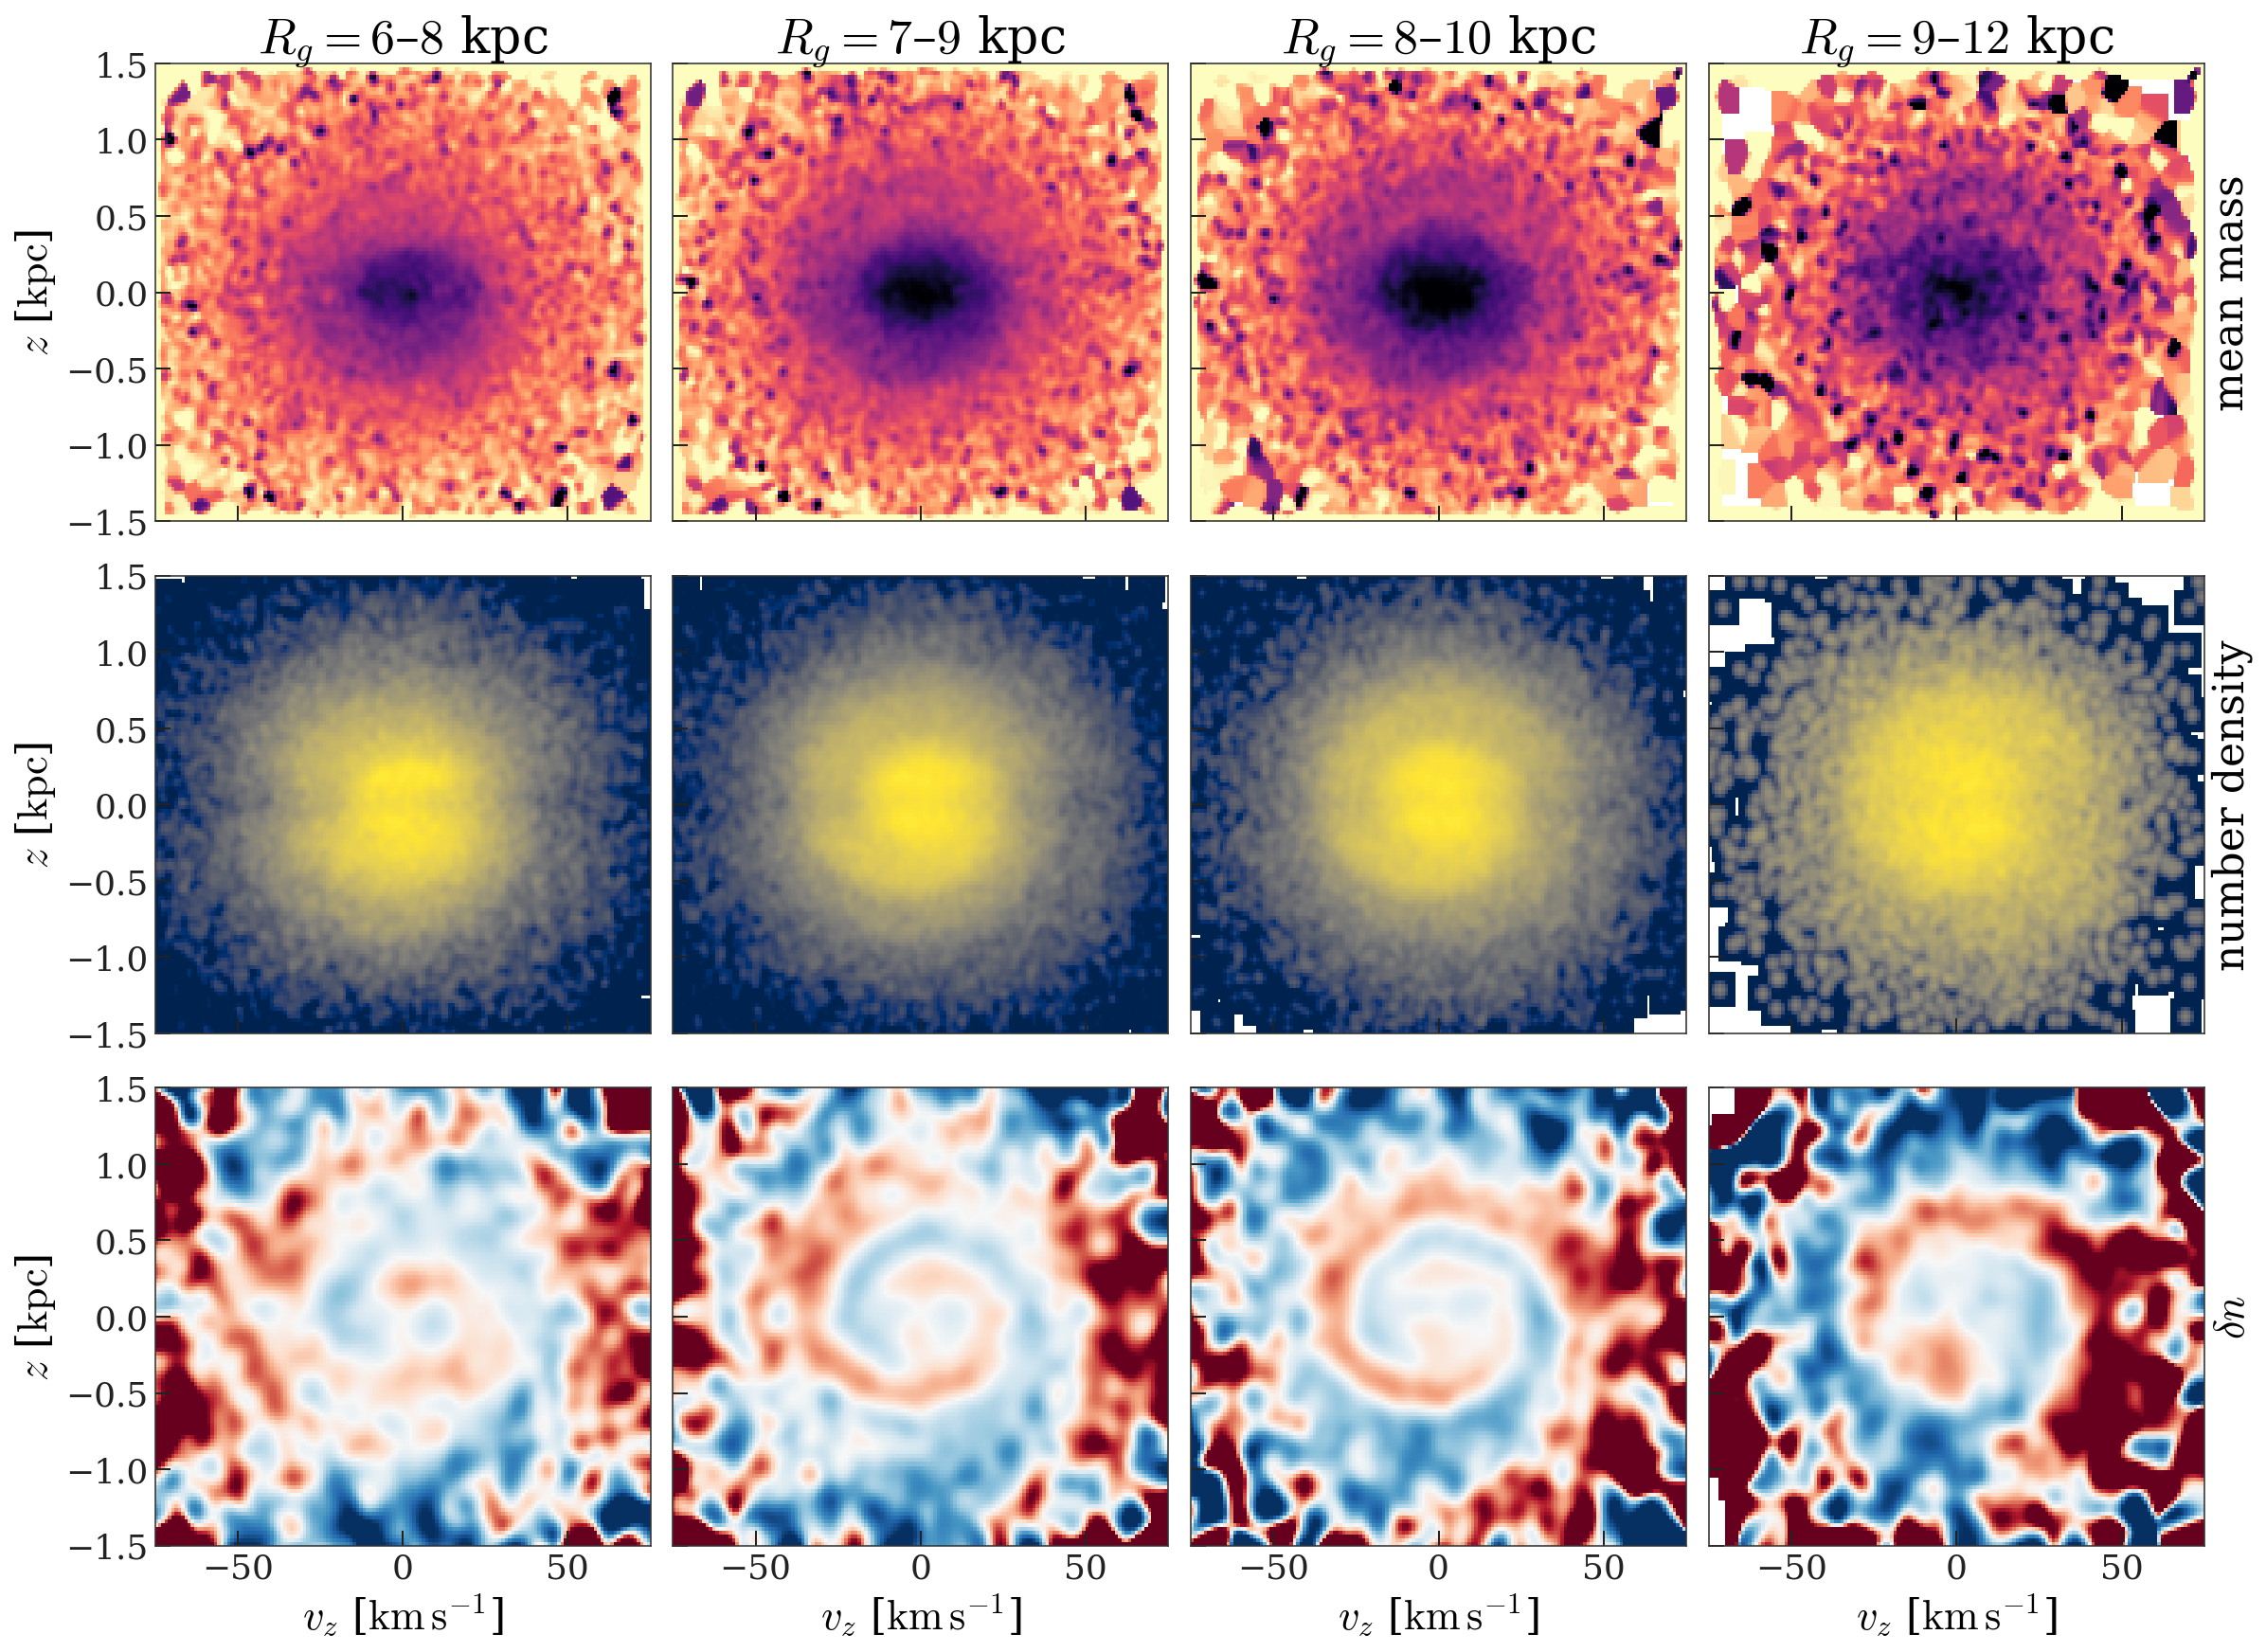

In [16]:
ncols = len(Lz_bins)
fig, all_axes = plt.subplots(
    3, ncols, figsize=(ncols*4 + 0.5, 4 * 3),
    sharex=True, sharey=True,
    constrained_layout=True
)

for i, ((Lz1, Lz2), (Rg1, Rg2)) in enumerate(zip(Lz_bins, Rg_bins)):
    axes = all_axes[:, i]

    Lz_mask = (Lz_solar > Lz1) & (Lz_solar <= Lz2)
    Lz_ctr = 0.5 * (Lz1 + Lz2)
    axes[0].set_title(f'$R_g = {Rg1.value:.0f}$–${Rg2.value:.0f}$ kpc')
    
    vz = galcen.v_z.to_value(u.km/u.s)[Lz_mask]
    z = galcen.z.to_value(u.kpc)[Lz_mask]
    mass = g.mass.value[Lz_mask]

    stat = binned_statistic_2d(
        vz, z, mass,
        statistic=np.mean,
        bins=vz_z_bins
    )
    kernel = Gaussian2DKernel(x_stddev=1.)
    H1 = convolve(stat.statistic.T, kernel)
    
    # ---
    
#     H2, xe, ye = np.histogram2d(
#         vz, z,
#         bins=vz_z_bins,
#     )
#     sm_kernel = Gaussian2DKernel(x_stddev=2.)
#     big_kernel = Gaussian2DKernel(x_stddev=5)
#     H2 = (convolve(H2, kernel) - convolve(H2, big_kernel)) / convolve(H2, big_kernel)
    
    H2, xe, ye = np.histogram2d(
        vz, z,
        bins=vz_z_bins,
        density=True
    )

    vz_scale = 1.5 * MAD(vz)
    z_scale = 1.5 * MAD(z)
    radius = np.sqrt((vz/vz_scale)**2 + (z/z_scale)**2)
    rng = np.random.default_rng(42)
    new_phi = np.arctan2(z/z_scale, vz/vz_scale)
    rng.shuffle(new_phi)

    new_vz = vz_scale * radius * np.cos(new_phi)
    new_z = z_scale * radius * np.sin(new_phi)

    H_shuff, xe, ye = np.histogram2d(
        new_vz, new_z,
        bins=vz_z_bins,
        density=True
    )
    
    kernel = Gaussian2DKernel(x_stddev=3)
    H_shuff = convolve(H_shuff.T, kernel)
    H_diff = (convolve(H2.T, kernel) - H_shuff) / H_shuff
        
    vmin, vmax = np.nanpercentile(g.mass.value, [5, 85])
    cs = axes[0].pcolormesh(
        stat.x_edge, stat.y_edge, 
        H1, 
        vmin=vmin, vmax=vmax,
        cmap='magma_r')
    
    this_H = convolve(H2.T, Gaussian2DKernel(x_stddev=1.))
    this_H = np.log(this_H)
    vmin, vmax = np.nanpercentile(this_H.ravel(), [15, 99.9])
    cs = axes[1].pcolormesh(
        xe, ye, this_H, 
        cmap='cividis',
        vmin=vmin, vmax=vmax)
    
    cs = axes[2].pcolormesh(
        xe, ye, H_diff, 
        cmap='RdBu_r', vmin=-0.5, vmax=0.5)

# cb = fig.colorbar(cs, ax=all_axes)
# cb.set_label('mean mass')
# cb.ax.set_aspect(30)

for ax in all_axes[-1]:
    ax.set_xlabel(f'$v_z$ [{u.km/u.s:latex_inline}]')
for ax in all_axes[:, 0]:
    ax.set_ylabel(f'$z$ [{u.kpc:latex_inline}]')
    
_labels = ['mean mass', 'number density', r'$\delta n$']
for ax, label in zip(all_axes[:, -1], _labels):
    ax.set_ylabel(label)
    ax.yaxis.set_label_position('right')

85873 109928
0.01916409342244543 km / s
0.010061374293251404 kpc
30697 33010
-0.08625289668917249 km / s
-0.004150989352578151 kpc
5452 5847
0.24502756745052956 km / s
-0.008573262880466878 kpc
945 1045
0.1422516715642357 km / s
-0.00240944585537977 kpc


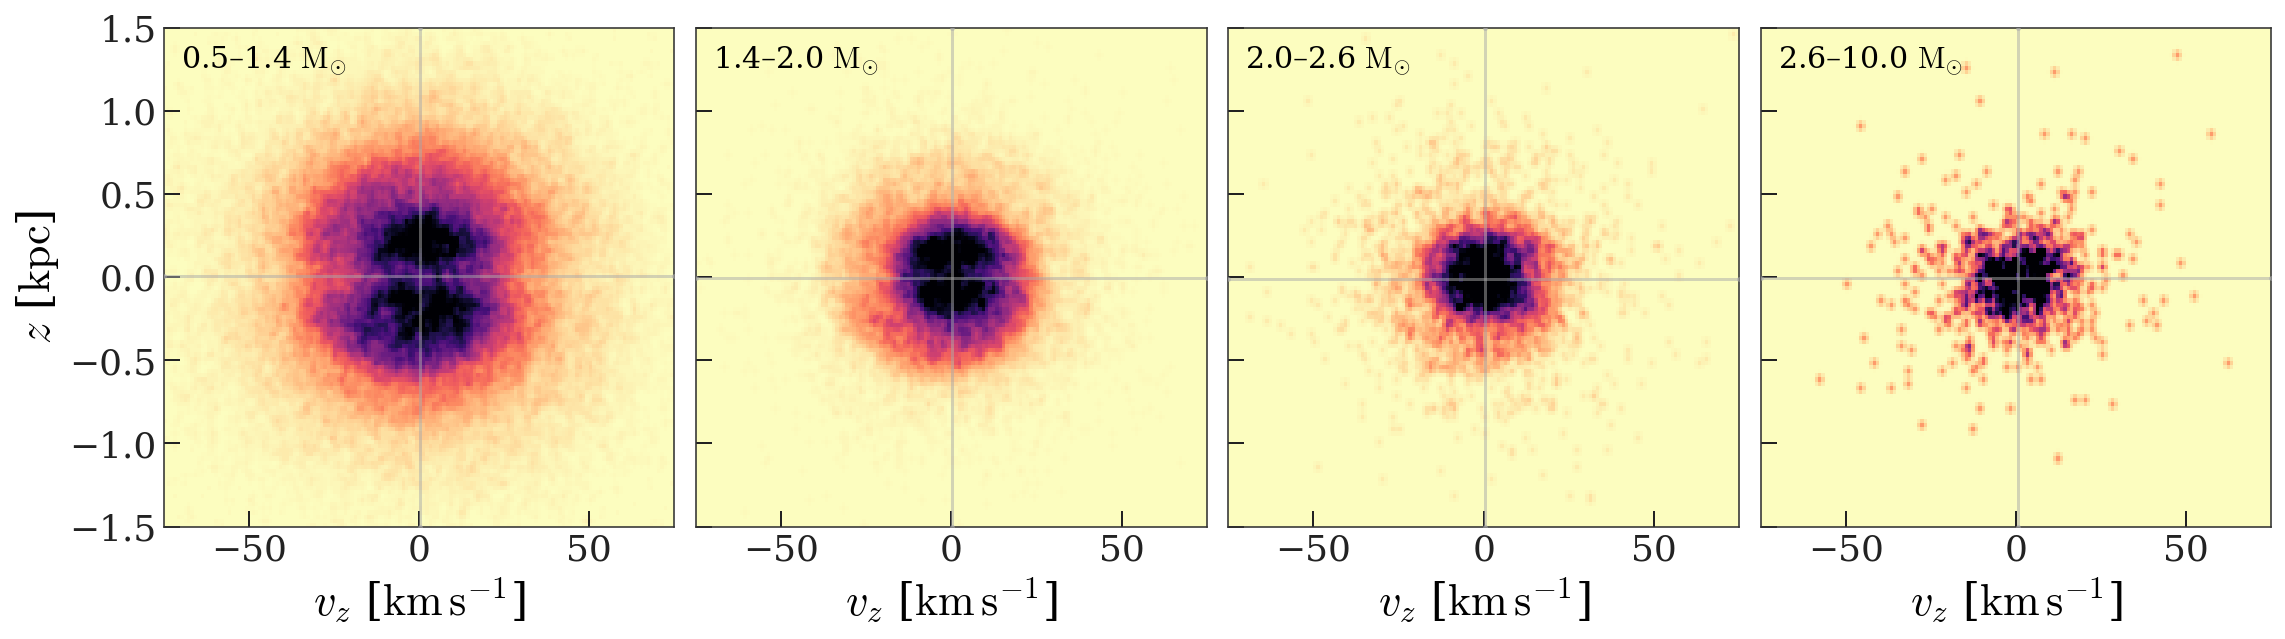

In [17]:
Lz_mask = np.abs(Lz_solar - 1) < 0.2

ncols = len(mass_bins)
fig, axes = plt.subplots(1, ncols,
                         figsize=(4*ncols, 4.6),
                         sharex=True, sharey=True)
    
for i, (m1, m2) in enumerate(mass_bins):
    ax = axes.flat[i]
    
    mass_mask = (g.mass.value > m1) & (g.mass.value < m2)
    mask = mass_mask & Lz_mask
    print(mask.sum(), mass_mask.sum())

    stat = binned_statistic_2d(
        galcen.v_z.to_value(u.km/u.s)[mask],
        galcen.z.to_value(u.kpc)[mask],
        galcen.z.to_value(u.kpc)[mask],
        statistic='count',
        bins=(np.arange(-75, 75+1e-3, 1.),
              np.arange(-1.5, 1.5+1e-3, 25/1e3))
    )
    
    H = stat.statistic.T

    kernel = Gaussian2DKernel(x_stddev=0.77)
    H = convolve(H, kernel)

    cs = ax.pcolormesh(
        stat.x_edge, stat.y_edge, H, 
        cmap='magma_r',
        vmin=np.percentile(H.ravel(), 1),
        vmax=np.percentile(H.ravel(), 99)) #, vmin=-0.5, vmax=0.5)
    
    ax.axvline(np.median(galcen.v_z.to_value(u.km/u.s)[mask]), 
               zorder=100, color='#aaaaaa', alpha=0.5)
    ax.axhline(np.median(galcen.z.to_value(u.kpc)[mask]), 
               zorder=100, color='#aaaaaa', alpha=0.5)
    
#     cb = fig.colorbar(cs)
#     cb.set_label('mean mass')

    print(np.mean(galcen.v_z.to(u.km/u.s)[mask]))
    print(np.mean(galcen.z.to(u.kpc)[mask]))
    
    ax.text(-70, 1.4, 
            f'{m1:.1f}–{m2:.1f} {u.Msun:latex_inline}',
            ha='left', va='top', fontsize=15)

for ax in axes:
    ax.set_xlabel(f'$v_z$ [{u.km/u.s:latex_inline}]')

ax = axes[0]
ax.set_ylabel(f'$z$ [{u.kpc:latex_inline}]')

fig.tight_layout()